La prueba consiste en programar un clasificador entre imágenes triste/contento dado el dataset
A realizar:
1. Generar CSV a partir de los datos con columnas ['ImagePath','Label']
2. Crear histograma de las clases
3. Entrenar y validar modelo de clasificación
4. Mostrar gráficas de loss/accuracy
5. Guardar el modelo entrenado
6. Puedes añadir algún comentario sobre algo que no te haya dado tiempo a programar o algo que harías para mejorar los resultados

- Se puede programar en colab/script de python o como se considere
- Realizar la tarea usando Keras
- Usar las librerías y modelo que se considere

# 1. Generar CSV a partir de los datos con columnas ['ImagePath','Label']

In [2]:
# Nunca había tenido que crear un csv, sino que siempre me lo daban. 
# Para hacerlo necesito las siguientes liberías (os: nueva para mí)

import os
import pandas as pd


Referencia: https://datascience.stackexchange.com/questions/49094/how-to-transform-a-folder-of-images-into-csv-file

In [3]:
# As I'm using google colab I had to *mount drive* in order to use my google drive directories
base_dir = '/content/drive/MyDrive/PruebaEmocional/' #You may have to change the base_dir
data_dir = base_dir + 'dataset/'

# Sad images
sad_folder = data_dir+'Sad/'
sad_files = sorted(os.listdir(sad_folder))
sad_images=[i for i in sad_files]
df_sad=pd.DataFrame()
df_sad['ImagePath']=[sad_folder + str(x) for x in sad_images]
df_sad['Label']=['Sad']*len(sad_images) 

# Happy images
happy_folder = data_dir+'Happy/'
happy_files = sorted(os.listdir(happy_folder))
happy_images=[i for i in happy_files]
df_happy=pd.DataFrame()
df_happy['ImagePath']=[happy_folder + str(x) for x in happy_images]
df_happy['Label']=['Happy']*len(happy_images) 


# We append both dfs into a single df:
df=df_sad.append(df_happy,ignore_index=True)
# We save the csv:
df.to_csv(data_dir+'Images.csv', encoding='utf-8', index=False)

# Therefore we can find our csv as: /content/drive/MyDrive/PruebaEmocional/dataset/Images.csv

# 2. Crear histograma de las clases

In [4]:
# Para la visualización vamos a usar matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Classes Histogram')

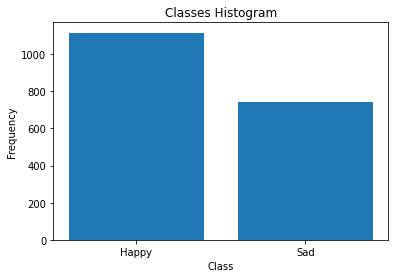

In [6]:
label_counts=df.Label.value_counts() # Label column contains strings, therefore it can't be plotted directly as df.Label.plot(kind='hist')
plt.bar(label_counts.index,label_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes Histogram')

# 3. Entrenar y validar modelo de clasificación

In [7]:
# Para crear y entrenar el modelo vamos a usar los siguiente paquetes
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import datetime

Referencias: 
- TensorFlow:  https://www.tensorflow.org/tutorials/
- LinkedinLearning. Course: TensorFlow: Working with Images, by Jonathan Fernandes

## Basic Keras Model

In [8]:
name='prueba'
batch_size = 32
img_height = 512
img_width = 512

In [13]:
train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=37,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=37,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1857 files belonging to 2 classes.
Using 1486 files for training.
Found 1857 files belonging to 2 classes.
Using 371 files for validation.


In [12]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Happy' 'Sad']


<Figure size 720x720 with 0 Axes>

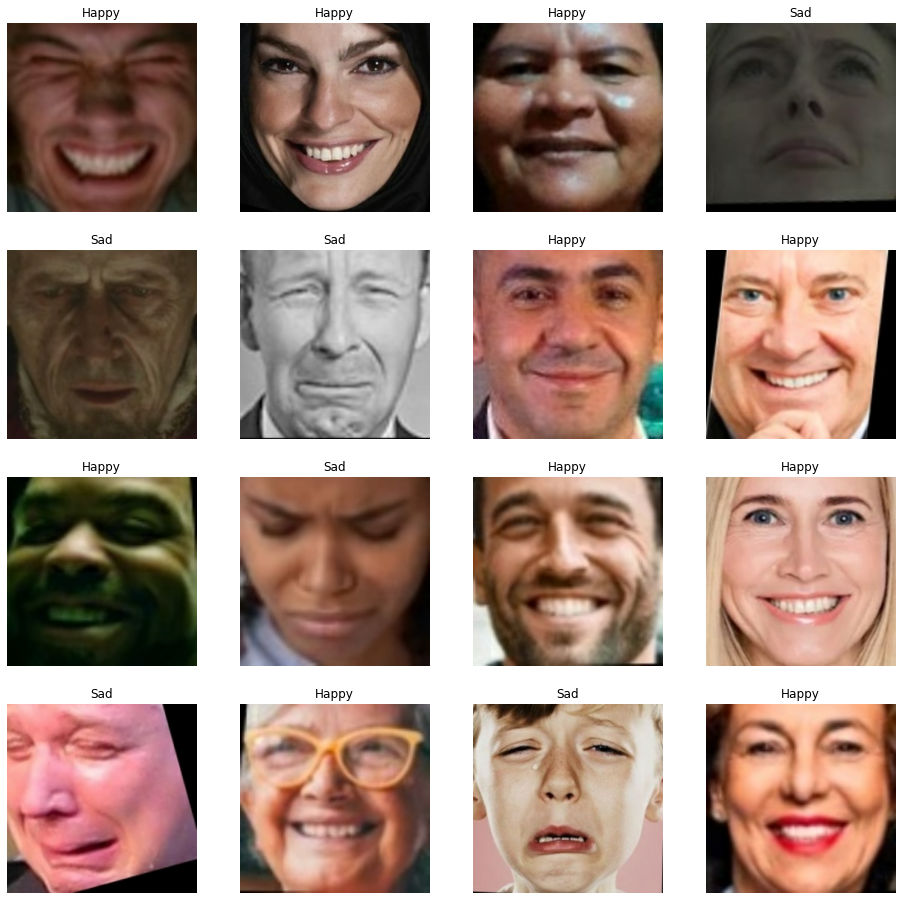

In [14]:
#Let's visualize some images

plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [16]:
# We need these importations to correctly interpretate our code
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [20]:
model = Sequential([
  data_augmentation,
  keras.layers.Rescaling(1./255),

  layers.Conv2D(2**4, 3, padding='same', activation='relu', name='First_Convolutional_Layer'),
  layers.MaxPooling2D(),
  

  layers.Conv2D(2**5, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(2**6, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(2**7, activation='relu'),
  layers.Dropout(0.25),

  layers.Dense(2**8, activation='relu'),
  layers.Dropout(0.25),

  layers.Dense(2**9, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(len(class_names), name='class')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 First_Convolutional_Layer (  (None, 512, 512, 16)     448       
 Conv2D)                                                         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 32)    

### Model checkpoints and earlystopping

In [21]:
checkpoint_filepath = base_dir +'models/tmp/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor='val_acc',
    save_weights_only=True,
    mode='max',
    save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_acc',
                                    patience=7)

callbacks = [checkpoint, early_stop]

### Compile and train

In [22]:
NUM_EPOCHS = 50

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=callbacks).history

Epoch 1/50
47/47 [==============================] - 112s 2s/step - loss: 0.8100 - acc: 0.5922 - val_loss: 0.6746 - val_acc: 0.6092
Epoch 2/50
47/47 [==============================] - 8s 171ms/step - loss: 0.6667 - acc: 0.5989 - val_loss: 0.6611 - val_acc: 0.6092
Epoch 3/50
47/47 [==============================] - 8s 170ms/step - loss: 0.6619 - acc: 0.5996 - val_loss: 0.6471 - val_acc: 0.6092
Epoch 4/50
47/47 [==============================] - 10s 206ms/step - loss: 0.6555 - acc: 0.6191 - val_loss: 0.6356 - val_acc: 0.6280
Epoch 5/50
47/47 [==============================] - 10s 210ms/step - loss: 0.6321 - acc: 0.6548 - val_loss: 0.5794 - val_acc: 0.6361
Epoch 6/50
47/47 [==============================] - 10s 216ms/step - loss: 0.5527 - acc: 0.7221 - val_loss: 0.4437 - val_acc: 0.7871
Epoch 7/50
47/47 [==============================] - 10s 217ms/step - loss: 0.4722 - acc: 0.7752 - val_loss: 0.4064 - val_acc: 0.8086
Epoch 8/50
47/47 [==============================] - 8s 175ms/step - loss:

In [ ]:
max_val_acc=round(10**4*max(history['val_acc']))
print(max_val_acc)

8922


### Load the best weights

In [ ]:
model.load_weights(checkpoint_filepath)

# 4. Mostrar gráficas de loss/accuracy

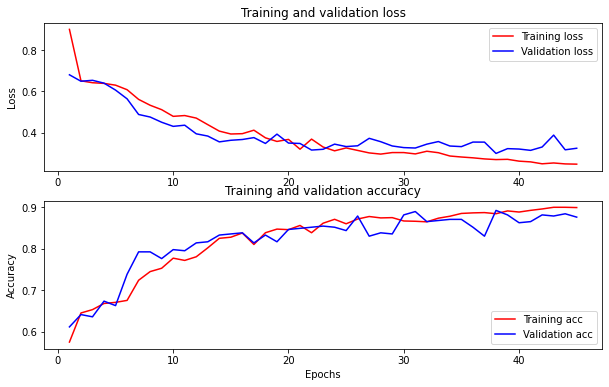

In [ ]:
# Las referencias son las mismas que en el apartado anterior
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 5.Guardar el modelo entrenado

In [ ]:
# Guardamos el modelo con el nombre del modelo utilizado, image width and height, batch size and val_acc 
model_name='model_' + name + '_iwh' + str(img_width) + '_bs' + str(batch_size) + '_acc' + str(max_val_acc)
model.save(base_dir + 'models/' + model_name)
print(model_name)

model_best_iwh512_bs32_acc8922


# 6. Puedes añadir algún comentario sobre algo que no te haya dado tiempo a programar o algo que harías para mejorar los resultados

Comentarios:
1. Inicialmente se ha transferido el modelo inception_v3, las imágenes se han establecido con shape (80,80,3) y batch_size=32, obteniendo un accuracy máximo de 0.8410.
2. Se experimento a importar otro modelo y crear un modelo de cero sin RGB solo grayscale pero no funcionaba bien.
3. Se crea un modelo mejor desde cero tomando buenas referencias para ello, con mayor número de neuronas. Se ha establecido con shape (512,512,3) y batch_size=32, obteniendo un accuracy máximo de 0.8922

Observaciones:
Se ha intentado hacer la visualización también con %tensorboard, pero no se ha conseguido resolver el error: 

Probable causes:

You haven’t written any data to your event files.
TensorBoard can’t find your event files.

In [ ]:
# Cargamos el modelo 
model_name_to_load = model_name
model = tf.keras.models.load_model(base_dir + 'models/' + model_name_to_load) 

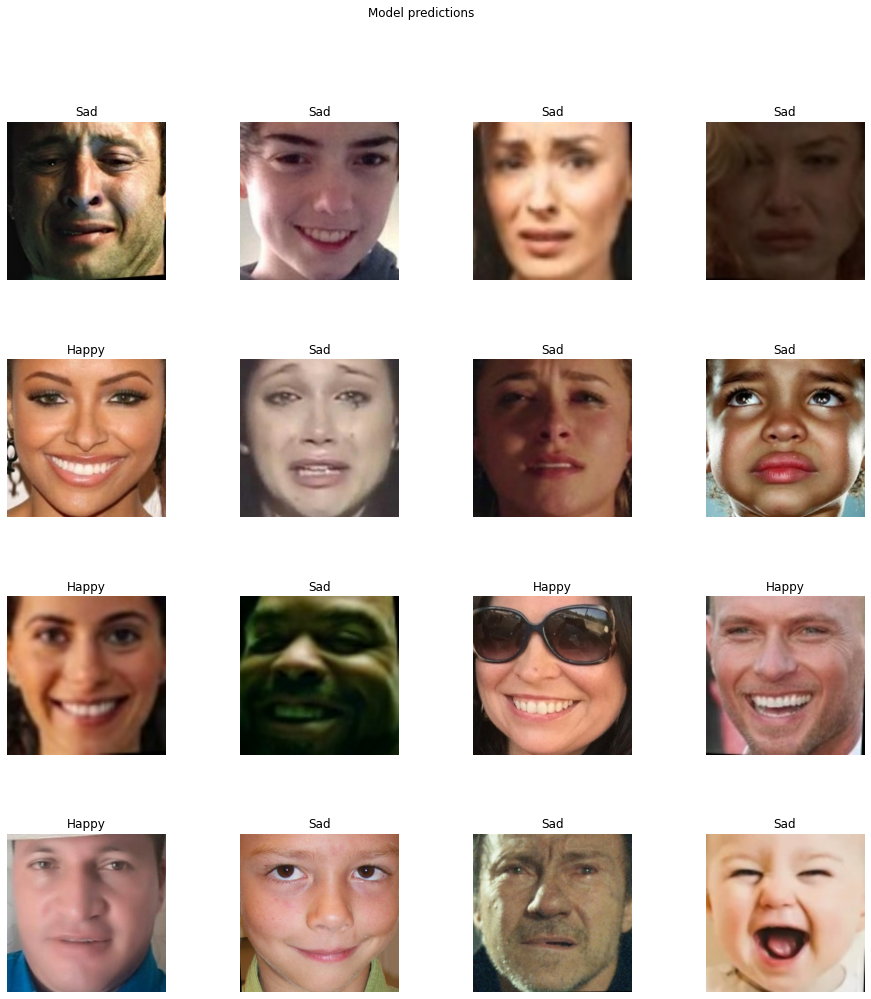

In [ ]:
# Vamos a visualizar algunos ejemplos de como catáloga las imágenes 
image_batch, labels = next(iter(val_ds))
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = [class_names[i] for i in predicted_id]

plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.5)

for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(image_batch[n]/255.)
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")